In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from importlib import reload
import os
from os.path import join
import subprocess
import sys
sys.path.append('../../') # lets us import ptype package from the subdir
#import ptype.
import time

import soundings.utils as utils
import soundings.mr_analysis as mra
from soundings.mr_analysis import SoundingQuery

In [2]:
#dir with aggregated data
data_dir = "/glade/work/dkimpara/ptype-aggs"


# mean soundings

select 

- variable to plot
- subset of data:
    - 'case_study_day' : 
        - 'new_york_1-20221215', 'new_york_1-20221216', 'new_york_1-20221217', 
        - 'new_york_2-20220203', 'new_york_2-20220204', 
        - 'kentucky-20220223','kentucky-20220224'
    - init_hr:
        - rap,hrrr: 0 - 23
    - step:
        - int in ns

In [3]:
var = 't_h'
select_case = {
               #'case_study_day': 'kentucky-20220224',
               #'init_hr': [0,2],
              }

color_dict = {'ML': '#FF7F0E',
              'NWP': '#1F77B4'}


lstyledict = {'t_h': 'solid',
              'dpt_h': 'dashed',
              'wb_h': 'dotted'}

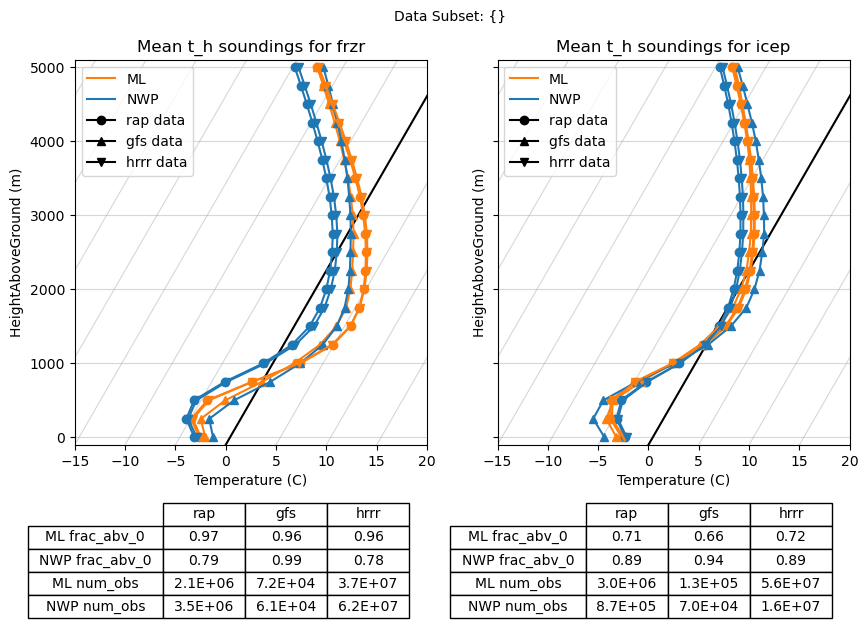

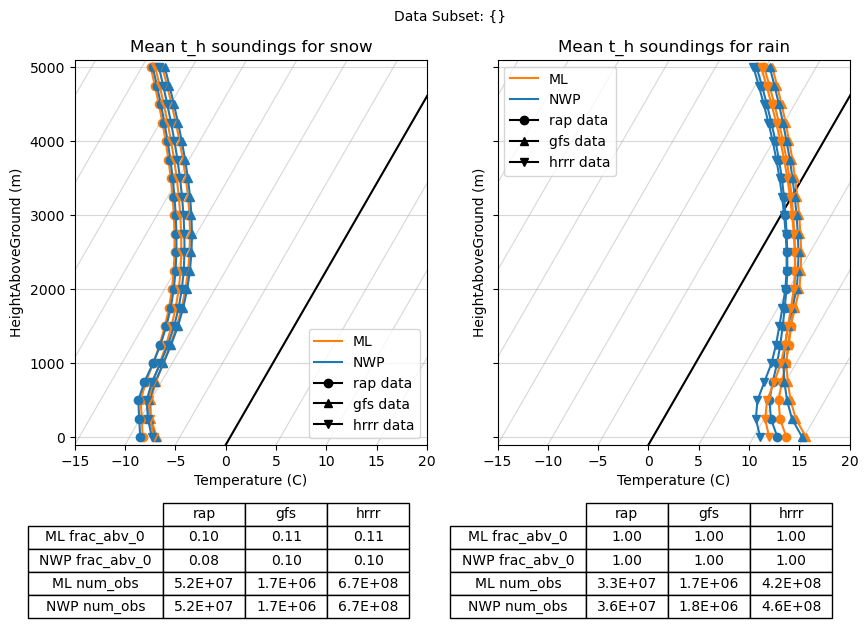

In [4]:
bad = ['cfrzr', 'cicep']
good = ['csnow', 'crain']
allptypes = [bad,good]
models = ['rap','gfs','hrrr'] 

def get_obs_and_frac(obs_frac, query, ptype, select_case):
    ml_frac = query.query(['ML_' + ptype], 't_h', 'fabv', select_case)['t_h_fabv'].values[0]
    nwp_frac = query.query([ptype], 't_h', 'fabv', select_case)['t_h_fabv'].values[0]
    
    ml_obs = query.num_obs('ML_' + ptype, select_case).values[0]
    nwp_obs = query.num_obs(ptype, select_case).values[0]
    
    for i, num in enumerate([ml_frac, nwp_frac, ml_obs, nwp_obs]):
        obs_frac[i].append(num)
    return obs_frac

def convert_obs_frac(obs_frac):
    obs_frac[0] = [f'{frac:.2f}' for frac in obs_frac[0]]
    obs_frac[1] = [f'{frac:.2f}' for frac in obs_frac[1]]
    obs_frac[2] = [f'{frac:.1E}' for frac in obs_frac[2]]
    obs_frac[3] = [f'{frac:.1E}' for frac in obs_frac[3]]
    return obs_frac
    
                   

for pair in allptypes:
    fig, axs = utils.skewCompositeFigAx(figsize=(10,5),num_subplots=2)


    for ax, ptype in zip(axs, pair):
        obs_frac = [[],[],[],[]]

        for model, marker in zip(models, ['o', '^', 'v']):
            ds = xr.open_dataset(join(data_dir,f"{model}_all.nc"), engine='netcdf4')
            query = SoundingQuery(ds)
            h = ds.heightAboveGround
            
            ml = query.query(['ML_' + ptype], ['t_h', 'dpt_h','wb_h'], 'mean', select_case)
            nwp = query.query([ptype], ['t_h', 'dpt_h','wb_h'], 'mean', select_case)
            ax.plot(ml[f'{var}_mean'].values.flatten(), h, 
                    color=color_dict['ML'], linestyle=lstyledict[var],marker=marker)
            ax.plot(nwp[f'{var}_mean'].values.flatten(), h, 
                    color=color_dict['NWP'], linestyle=lstyledict[var],marker=marker)
            ### setting plot text
            ax.set_title(f'Mean {var} soundings for {ptype[1:]}')
            ax.set_xlim(-15,20)
            ax.set_xlabel('Temperature (C)')
            ax.set_ylabel('HeightAboveGround (m)')
            if model=='rap':
                line, = ax.plot([],[], color=color_dict['ML'])
                line.set_label('ML')
                line, = ax.plot([],[], color=color_dict['NWP'])
                line.set_label('NWP')

            line, = ax.plot([],[], marker=marker, color='0')
            line.set_label(f'{model} data')
            ax.legend()

            obs_frac = get_obs_and_frac(obs_frac, query, ptype, select_case)
        #now plot the table below
        obs_frac = convert_obs_frac(obs_frac)
        ax.table(obs_frac,
                   rowLabels=['ML frac_abv_0', 'NWP frac_abv_0', 'ML num_obs', 'NWP num_obs'],
                   colLabels=models,
                   cellLoc = 'center', rowLoc = 'center',
                   loc='bottom', bbox=[0.25, -0.45, 0.7, 0.3]
                )
    fig.suptitle(f'Data Subset: {select_case}', fontsize=10)